In [2]:
import os
import shutil
from PIL import Image
import pandas as pd
import numpy as np
import shutil

In [2]:
# Check for black pixels in an image:
def check_black(image):
    contains_black = False
    black = (0,0,0)
    colours = image.getcolors()
    for colour in colours:
        if colour[1] == black:
            contains_black = True
    return contains_black

In [216]:
# Extract only PNGs
labels = './annotated/results/'
pngs = []
npz = []

for file in os.listdir(labels):
    if file[-3:] == 'png':
        pngs.append(file) # Add directory to name
    
    elif file[-3:] == 'npz':
        npz.append(file) # Add directory to name

# Go through all labels to identify black pixels:
contains_black = []
for png in pngs:
    img = Image.open(labels+png)
    contains_black.append(check_black(img))

# Display findings:
pd.Series(contains_black).value_counts()

False    138
True      66
Name: count, dtype: int64

In [3]:
# 
def get_identity(png_filename):
    stripped_name = png_filename.replace('./annotated/results/','').split('_')[0:4]
    identity = '_'.join(stripped_name)
    return identity

In [218]:
# This was used to identify which colour is purple (by RGB value):
Image.open(labels+pngs[1]).getcolors()

[(244058, (220, 57, 18)),
 (83, (153, 0, 153)),
 (4194, (51, 102, 204)),
 (1665, (16, 150, 24))]

In [58]:
# Shade of purple identified for 'other' class
other_label = (153, 0, 153)

In [4]:
#test_img = Image.open(pngs[0])
def replace_black(img):
    data = np.array(img)   # "data" is a height x width x 4 numpy array
    red, green, blue = data.T # Temporarily unpack the bands for readability

    black_areas = (red == 0) & (blue == 0) & (green == 0)
    data[..., :][black_areas.T] = other_label # Transpose back needed

    cleaned_img = Image.fromarray(data)
    return cleaned_img

In [5]:
def get_identifier(png_name):
        stripped_name = png_name.split('_')[0:4]
        identity = '_'.join(stripped_name)
        return identity

In [6]:
def find_npz(file_id,npz_list):
    for npz in npz_list:
        if file_id in npz:
            return npz

In [7]:
def count_black(image_directory):
    labels = './annotated/results/'
    image = Image.open(labels+image_directory)
    black = (0,0,0)
    colours = image.getcolors()
    for colour in colours:
        if colour[1] == black:
            return colour[0]

In [8]:
# Get number of labels applied to image based on npz file.
def get_unique_labels(npz_file_directory):
    labels = './annotated/results/'
    npz = np.load(labels+npz_file_directory)
    return npz['label'].shape[2]

# Get number of different pixels of annotation png image.
def get_unique_pixels(png_directory):
    labels = './annotated/results/'
    png = Image.open(labels+png_directory)
    return len(png.getcolors())

Create dataframe of all images for summary purposes.

In [661]:
# Puit npz files into dataframe.
npz_frame = pd.DataFrame()
npz_frame['npz_filename'] = pd.Series(npz)
npz_frame['file_id'] = npz_frame['npz_filename'].apply(get_identifier)

In [545]:
all_results = pd.DataFrame()
all_results['png_filename'] = pngs
all_results['file_id'] = all_results['png_filename'].apply(get_identifier)
all_results['season'] = all_results['file_id'].apply(lambda x: 'autumn' if x[-8:] == '20180917' else 'spring') #Classify into spring/autumn pictures.
all_results['black_pixels'] = all_results['png_filename'].apply(count_black).fillna(0)
all_results['black_proportion'] = (all_results['black_pixels']/(500*500)).round(4).fillna(0)
all_results = all_results.merge(npz_frame,how='inner')
all_results['labels_npz'] = all_results['npz_filename'].apply(get_unique_labels)
all_results['labels_png'] = all_results['png_filename'].apply(get_unique_pixels)
all_results['labels_diff'] = all_results['labels_npz'] - all_results['labels_png']

<Axes: >

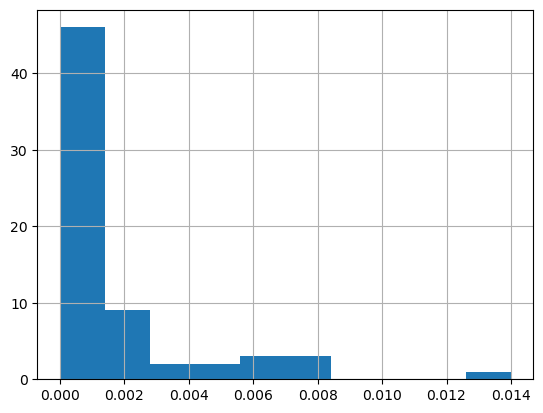

In [367]:
# Proportion of black pixels per image:
results['black_proportion'].hist()

In [377]:
# Finding the worst image:
results[results['black_proportion'] == results['black_proportion'].max()]

,png_filename,file_id,npz_filename,season,black_count,black_proportion
36,005_05_18_20180917_label2023-05-25-08-49_Micha...,005_05_18_20180917,005_05_18_20180917_Michael.npz,autumn,3503,0.014


In [13]:
# Reclassification of pixels to each class based on PNG file
unknown_px = [0,0,0]
grey_px = [220, 57, 18]
other_px = [153, 0, 153]
sand_px = [51, 102, 204]
white_px = [255, 153, 0]
shrubs_px = [16, 150, 24]

unknown_lab = [0,0,0,0,1]
grey_lab = [0,1,0,0,0]
other_lab = unknown_lab
sand_lab = [1,0,0,0,0]
white_lab = [0,0,1,0,0]
shrubs_lab = [0,0,0,1,0]

def reclassify_pixels(pixel):
    #unknown = np.array([0,0,0])
    grey_dunes = np.array([220, 57, 18])
    #other = np.array([153, 0, 153])
    sand = np.array([51, 102, 204])
    white_dunes = np.array([255, 153, 0])
    shrubs = np.array([16, 150, 24])

    if np.array_equiv(pixel, shrubs):
        return np.array([0,0,0,1,0])
    if np.array_equiv(pixel, sand):
        return np.array([1,0,0,0,0])
    if np.array_equiv(pixel, grey_dunes):
        return np.array([0,1,0,0,0])
    if np.array_equiv(pixel,white_dunes):
        return np.array([0,0,1,0,0])
    else:
        return np.array([0,0,0,0,1])

In [9]:
# Returns a label for a given png file:
def classify(png_img):
    reshaped_pixels = np.asanyarray(png_img).reshape(500**2,3)
    label = []
    for pixel in reshaped_pixels:
        label.append(reclassify_pixels(pixel))
    label = np.reshape(np.array(label), [500,500,5])# Return to original shape
    return label

In [10]:
# Takes npz file as input and replaces label array with new one, then saves to filename given.
def adjust_npz_file(npz_file,label,filename):
    image = npz_file['image']
    orig_image = npz_file['orig_image']
    color_doodles = npz_file['color_doodles']
    doodles = npz_file['doodles']
    settings = npz_file['settings']
    classes = npz_file['classes']

    np.savez_compressed(filename,image = image,
                                  orig_image = orig_image,
                                  label = label,
                                  color_doodles = color_doodles,
                                  doodles = doodles,
                                  settings = settings,
                                  classes = classes)

In [11]:
def fix_npz(npz_file_directory):
    old_n = np.load(npz_file_directory)
    reshaped_label = old_n['label'].reshape(500**2,5)

    # Get the maximum array length:
    length_array = 0
    for label in reshaped_label:
        if np.max(np.nonzero(label)) > length_array:
            length_array = np.max(np.nonzero(label))

    fixed_n = []
    for item in reshaped_label:
        fixed_n.append(item[0:length_array+1])
    fixed_n = np.array(fixed_n)
    return fixed_n.reshape(500,500,fixed_n.shape[1])

In [560]:
# Check equivalence for selected image (testing):
test_img = Image.open(labels+all_results['png_filename'][52])
test_npx = np.load(labels + all_results['npz_filename'][52])
reshaped_pixels = np.asanyarray(test_img).reshape(500**2,3)
a = []
for pixel in reshaped_pixels:
    a.append(reclassify_pixels(pixel))
a = np.reshape(np.array(a), [500,500,5])# Reshape and do things

# Test equivalence between test image and actual labels:
np.array_equiv(test_npx['label'],a)

In [659]:
# Copy problematic images to new folder:
# First png files:
for file in all_results[all_results['season'] =='spring']['png_filename']:
    shutil.copy(labels+file, './annotated/spring/'+file)

# Then npz files:
for file in all_results[all_results['season'] =='spring']['npz_filename']:
    shutil.copy(labels+file, './annotated/spring/'+file)

In [660]:
# Put usable images in separate directory:
for file in all_results[all_results['season'] =='autumn']['png_filename']:
    shutil.copy(labels+file, './annotated/autumn/'+file)

# Then npz files:
for file in all_results[all_results['season'] =='autumn']['npz_filename']:
    shutil.copy(labels+file, './annotated/autumn/'+file)

Re-create the 'label' component of each autumn NPZ file

In [665]:
# Create dictionary of problematic files:
autumn = all_results[all_results['season']=='autumn'][['png_filename','npz_filename']]
autumn = autumn.set_index('npz_filename')
autumn_dict = autumn.to_dict()['png_filename']
autumn_dir = './annotated/autumn/'

for npz,png in autumn_dict.items():
    png_image = Image.open(autumn_dir+png) 
    new_label = classify(png_image)
    npz_file = np.load(autumn_dir+npz)
    adjust_npz_file(npz_file,new_label,autumn_dir+npz)

In [15]:
# Do the same for two lists of files:
os.getcwd()

fixed_dir = './annotated/combined_small/'
fixed_aut_pngs = [x for x in os.listdir(fixed_dir) if x[-3:]=='png']
fixed_aut_npz = [x for x in os.listdir(fixed_dir) if x[-3:]=='npz']

# Fix ordering of npz:
fixed_aut_npz.sort()
fixed_aut_pngs.sort()

# Check that they're the same
id_png = [get_identity(x) for x in fixed_aut_pngs]
id_npz = [get_identity(x) for x in fixed_aut_npz]
id_png == id_npz


for i,png in enumerate(fixed_aut_pngs):
    png_image = Image.open(fixed_dir+png) 
    new_label = classify(png_image)
    npz_file = np.load(fixed_dir+fixed_aut_npz[i])
    adjust_npz_file(npz_file,new_label,fixed_dir+fixed_aut_npz[i])


In [810]:
new_labs = './annotated/spring/usable/labels/original/'
fixed_labs = './annotated/spring/usable/labels/fixed/'
for label in os.listdir(new_labs):
    if label[-3:] == 'jpg':
        label_array = np.array(Image.open(new_labs + label))
        label_array[label_array == 5] = 4
        Image.fromarray(label_array).save(fp=fixed_labs+label,format='jpeg',quality = 100)